# Superconduct dataset - linear regression

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, RMSEModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent, FL_VanillaSGD
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataClustering import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "superconduct"

nb_devices_for_the_run = 20

In [2]:
import pandas as pd
data = pd.read_csv('../dataset/superconduct/train.csv', sep=",")
data.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [3]:
print(data.columns.values)

['number_of_elements' 'mean_atomic_mass' 'wtd_mean_atomic_mass'
 'gmean_atomic_mass' 'wtd_gmean_atomic_mass' 'entropy_atomic_mass'
 'wtd_entropy_atomic_mass' 'range_atomic_mass' 'wtd_range_atomic_mass'
 'std_atomic_mass' 'wtd_std_atomic_mass' 'mean_fie' 'wtd_mean_fie'
 'gmean_fie' 'wtd_gmean_fie' 'entropy_fie' 'wtd_entropy_fie' 'range_fie'
 'wtd_range_fie' 'std_fie' 'wtd_std_fie' 'mean_atomic_radius'
 'wtd_mean_atomic_radius' 'gmean_atomic_radius' 'wtd_gmean_atomic_radius'
 'entropy_atomic_radius' 'wtd_entropy_atomic_radius' 'range_atomic_radius'
 'wtd_range_atomic_radius' 'std_atomic_radius' 'wtd_std_atomic_radius'
 'mean_Density' 'wtd_mean_Density' 'gmean_Density' 'wtd_gmean_Density'
 'entropy_Density' 'wtd_entropy_Density' 'range_Density'
 'wtd_range_Density' 'std_Density' 'wtd_std_Density'
 'mean_ElectronAffinity' 'wtd_mean_ElectronAffinity'
 'gmean_ElectronAffinity' 'wtd_gmean_ElectronAffinity'
 'entropy_ElectronAffinity' 'wtd_entropy_ElectronAffinity'
 'range_ElectronAffinity' 'w

In [4]:
with pd.option_context('display.max_columns', 80):
    print(data.describe(include='all'))

       number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
count        21263.000000      21263.000000          21263.000000   
mean             4.115224         87.557631             72.988310   
std              1.439295         29.676497             33.490406   
min              1.000000          6.941000              6.423452   
25%              3.000000         72.458076             52.143839   
50%              4.000000         84.922750             60.696571   
75%              5.000000        100.404410             86.103540   
max              9.000000        208.980400            208.980400   

       gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
count       21263.000000           21263.000000         21263.000000   
mean           71.290627              58.539916             1.165608   
std            31.030272              36.651067             0.364930   
min             5.320573               1.960849             0.000000   
25%            58.

In [5]:
dim_notebook = len(data.columns) - 1
print("There is " + str(dim_notebook) + " dimensions.")

There is 81 dimensions.


In [6]:
if data.isnull().values.any():
    print("There is missing value.")
else:
    print("No missing value. Great !")

No missing value. Great !


In [7]:
X_data = data.loc[:, data.columns != "critical_temp"]
Y_data = data.loc[:, data.columns == "critical_temp"]
dim_notebook = len(X_data.columns)
print("There is " + str(dim_notebook) + " dimensions.")

There is 81 dimensions.


# IID data

In [8]:
def superconduct_step_size(it, L, omega, N): return 1 / (8 * L)

In [9]:
#Data normalisation
X_data = scale(X_data)
Y_data = scale(Y_data)

In [10]:
X_merged = torch.tensor(X_data, dtype=torch.float64)
Y_merged = torch.tensor(Y_data, dtype=torch.float64)
number_of_items = len(X_merged)
number_of_items_by_devices = number_of_items // nb_devices_for_the_run
print("Number of points by devices: ", number_of_items_by_devices)

X, Y = [], []
for i in range(nb_devices_for_the_run):
    X.append(X_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)])
    Y_temp = Y_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)]
    Y.append(torch.stack([y[0] for y in Y_temp]))
print("There is " + str(len(X)) + " devices.")


# Adding a columns of "1" to take into account a potential bias.
X = add_bias_term(X)
print(X[0].shape)

Number of points by devices:  1063
There is 20 devices.
torch.Size([1063, 82])


In [11]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(RMSEModel, X, Y, nb_devices_for_the_run)

In [12]:
%%time
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook + 1, 
                                                nb_devices=nb_devices_for_the_run,
                                                nb_epoch=50000, 
                                                quantization_param=0,
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                                    ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min, filename + "-obj_min")

   it    |   obj   
   10000 | 2.6969e-01
   20000 | 2.6645e-01
   30000 | 2.6539e-01
   40000 | 2.6491e-01
Gradient Descent: execution time=5749.313 seconds
Final loss : 0.26463

CPU times: user 4h 20min 18s, sys: 45min 32s, total: 5h 5min 50s
Wall time: 1h 35min 49s


Text(0.5, 0, 'true value (normalized)')

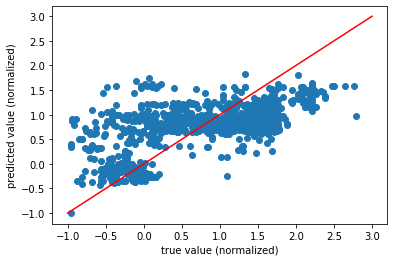

In [13]:
plt.scatter(Y[0], X[0].mv(obj_min_by_N_descent.model_params[-1]))
plt.plot(np.linspace(-1, 3, 2), np.linspace(-1, 3, 2), color='r')
plt.ylabel("predicted value (normalized)")
plt.xlabel("true value (normalized)")

In [14]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models = cost_models, 
                                               step_formula=superconduct_step_size,
                                               use_averaging=True, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

100%|██████████| 5/5 [12:44:35<00:00, 9175.09s/it]

CPU times: user 8h 15min 44s, sys: 8min 22s, total: 8h 24min 6s
Wall time: 12h 44min 35s


In [15]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

Model obtain from Vanilla SGD descent, the first value corresponds to the bias: 
tensor([ 0.0011, -0.1630,  0.2483, -0.1043, -0.0163, -0.0710, -0.3561,  0.1430,
         0.3215, -0.0039, -0.1263, -0.1450,  0.0345,  0.0640, -0.0050, -0.0007,
         0.0925,  0.2040,  0.5010,  0.0906, -0.3708, -0.1595,  0.1989,  0.4584,
        -0.3570, -0.2424,  0.0048,  0.2574,  0.4440, -0.1036, -0.5519,  0.3051,
        -0.2389, -0.0501,  0.0085,  0.2242,  0.1570, -0.2125, -0.1436,  0.0172,
         0.2187, -0.0737, -0.0110,  0.3910,  0.0657, -0.4186,  0.0270, -0.1978,
        -0.5702, -0.1397,  0.6791, -0.2499,  0.1152, -0.1208, -0.0780,  0.0417,
        -0.1036,  0.2466, -0.2163,  0.1346,  0.1115, -0.0582, -0.0045,  0.5609,
        -0.1187, -0.2660,  0.0257,  0.0847, -0.2463, -0.2340,  0.1425,  0.2032,
        -0.0289, -0.0155,  0.0856, -0.0837,  0.2219, -0.3296,  0.1739,  0.0770,
        -0.0398, -0.2332], dtype=torch.float64)


## Without averaging

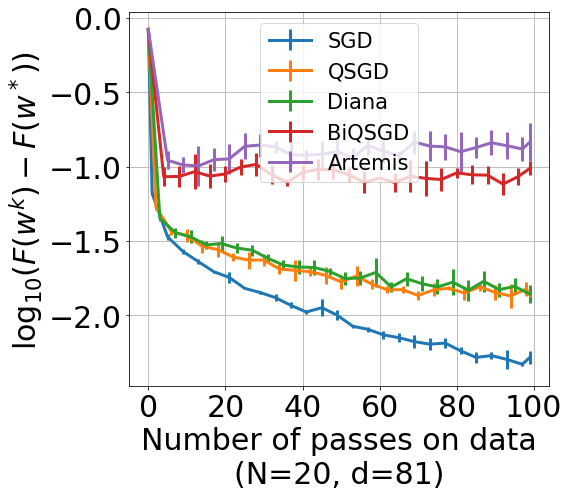

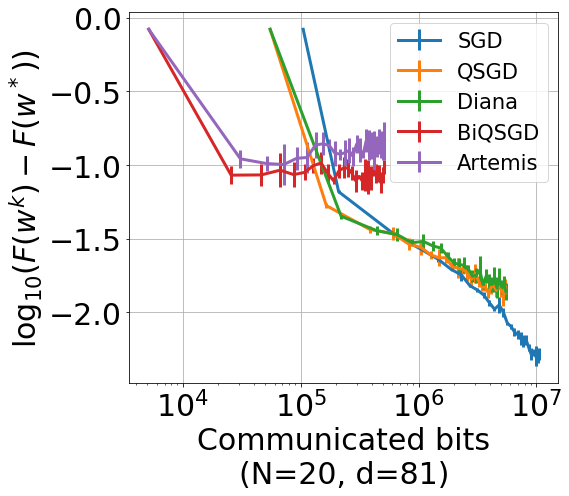

In [16]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj)) 

## With averaging

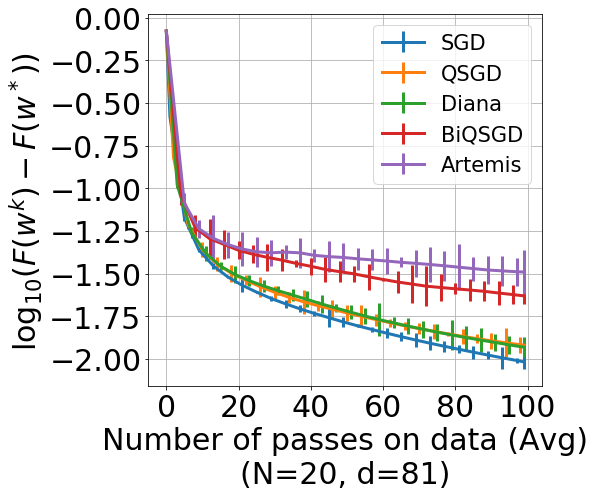

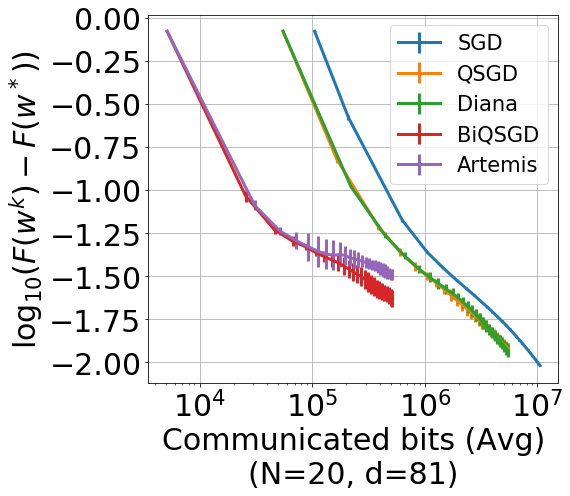

In [17]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=False), x_legend="Number of passes on data (Avg)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), x_legend="Communicated bits (Avg)") 


# Handling non-iid data

CPU times: user 20min 42s, sys: 2min 8s, total: 22min 51s
Wall time: 3min 59s


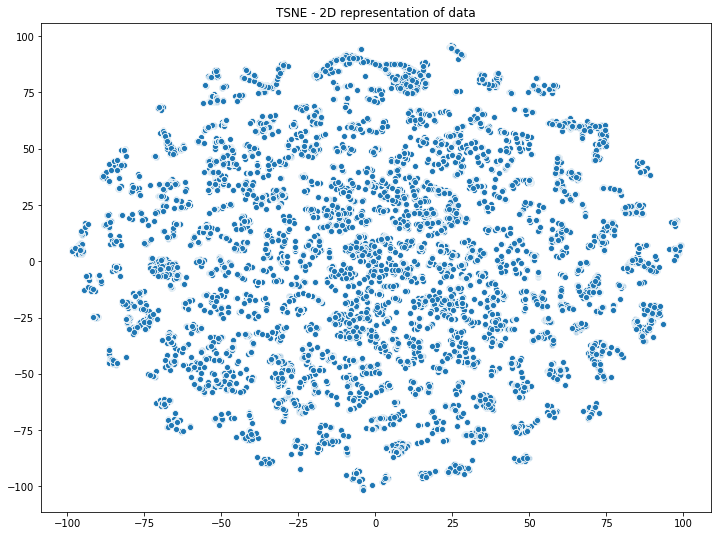

In [18]:
%%time
# Running TNSE to obtain a 2D representation of data
embedded_data = tsne(data)
pickle_saver(embedded_data, "{0}-tsne".format(filename))

superconduct-tsne
There is 20 devices.
Number of points on device 0 : 1345
Number of points on device 1 : 807
Number of points on device 2 : 3875
Number of points on device 3 : 505
Number of points on device 4 : 643
Number of points on device 5 : 3383
Number of points on device 6 : 1581
Number of points on device 7 : 2069
Number of points on device 8 : 243
Number of points on device 9 : 733
Number of points on device 10 : 1120
Number of points on device 11 : 788
Number of points on device 12 : 409
Number of points on device 13 : 417
Number of points on device 14 : 566
Number of points on device 15 : 901
Number of points on device 16 : 717
Number of points on device 17 : 301
Number of points on device 18 : 573
Number of points on device 19 : 287
CPU times: user 1h 25min 8s, sys: 12min 53s, total: 1h 38min 2s
Wall time: 13min 1s


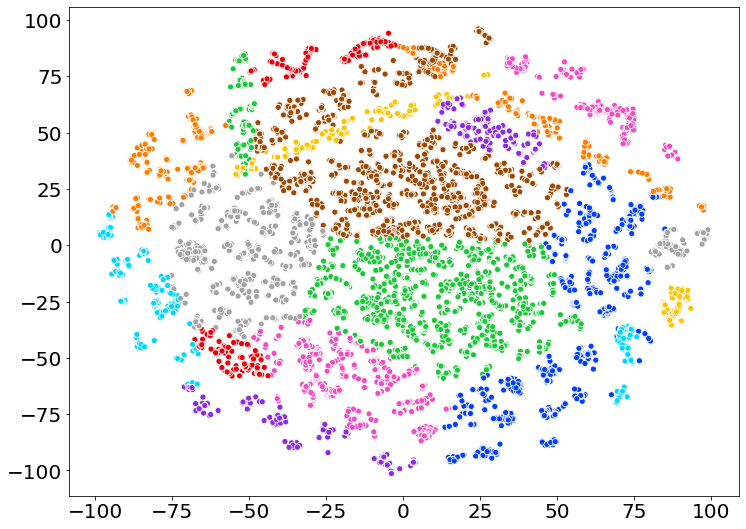

In [19]:
%%time
nb_cluster = nb_devices_for_the_run
print("{0}-tsne".format(filename))
embedded_data = pickle_loader("{0}-tsne".format(filename))
# Finding clusters in the TNSE
predicted_cluster = find_cluster(embedded_data, nb_cluster)
# With the found clusters, splitting data. 
X, Y = clustering_data(data, predicted_cluster, "critical_temp", nb_cluster, scale_Y=True)
dim_notebook = X[0].shape[1] - 1

CPU times: user 20min 7s, sys: 2min 3s, total: 22min 11s
Wall time: 3min 51s


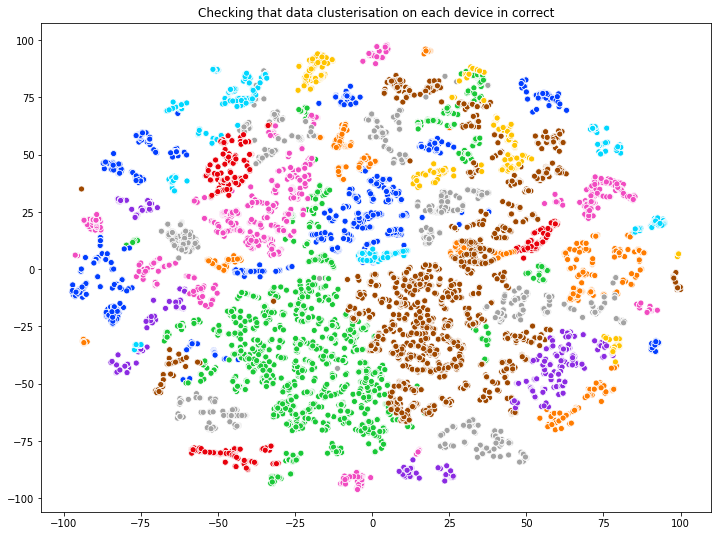

In [20]:
%%time
#Checking that splitting data by cluster is valid.
check_data_clusterisation(X,Y, nb_cluster)

In [21]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(RMSEModel, X, Y, nb_devices_for_the_run)

In [22]:
%%time
obj_min_by_N = {}
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook + 1, 
                                                nb_devices=nb_devices_for_the_run,
                                                nb_epoch=50000, 
                                                quantization_param=0,
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                                ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]

pickle_saver(obj_min, filename + "-noniid-obj_min")

   it    |   obj   
   10000 | 3.1715e-01
   20000 | 3.1302e-01
   30000 | 3.1142e-01
   40000 | 3.1059e-01
Gradient Descent: execution time=2198.654 seconds
Final loss : 0.31010

CPU times: user 4h 44s, sys: 36min 10s, total: 4h 36min 54s
Wall time: 36min 38s


## Batch size $= 1$ (stochastic)

In [23]:
%%time
all_descent = {}
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models,
                                               use_averaging=True, stochastic=True,
                                               step_formula=superconduct_step_size,
                                               logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, filename + "-noniid-descent")

100%|██████████| 5/5 [1:46:06<00:00, 1273.26s/it]

CPU times: user 3h 20min 31s, sys: 8min 50s, total: 3h 29min 22s
Wall time: 1h 46min 6s


In [24]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

Model obtain from Vanilla SGD descent, the first value corresponds to the bias: 
tensor([ 0.0172,  0.0093,  0.0928, -0.0286,  0.0682,  0.0426, -0.0874,  0.0799,
         0.2707, -0.0283,  0.1154, -0.1515, -0.0135,  0.0221,  0.0586,  0.0711,
         0.0815,  0.0368,  0.1336,  0.1003, -0.1734, -0.1442,  0.0132,  0.2280,
        -0.0984,  0.0357,  0.0526,  0.1174,  0.2181, -0.2372, -0.0773,  0.2061,
        -0.1362, -0.0527, -0.1064,  0.0350, -0.0524, -0.1613, -0.1514,  0.0851,
         0.1116, -0.1362,  0.1645,  0.0650,  0.0024, -0.2549, -0.0697, -0.1994,
        -0.2838, -0.1291,  0.3213, -0.1156,  0.0654, -0.0129, -0.0423, -0.0423,
        -0.0044,  0.2373, -0.0581,  0.1237, -0.0124, -0.0703,  0.0651,  0.3984,
        -0.0549, -0.2479, -0.0183,  0.1434, -0.1180, -0.1378, -0.0081,  0.2746,
         0.0031, -0.0384,  0.0298, -0.0297,  0.0392, -0.0470,  0.0415,  0.1488,
         0.0078, -0.2265], dtype=torch.float64)


## Without averaging

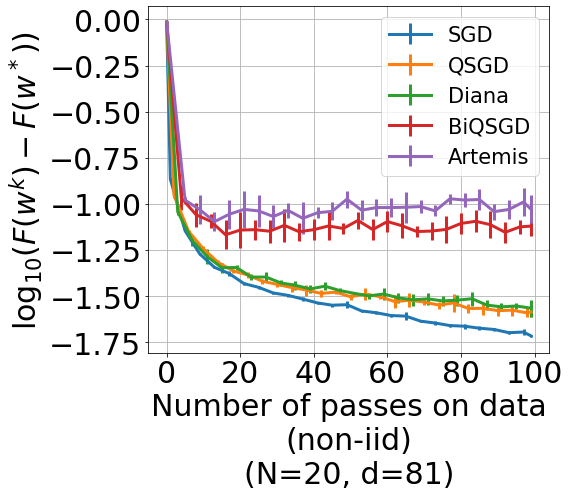

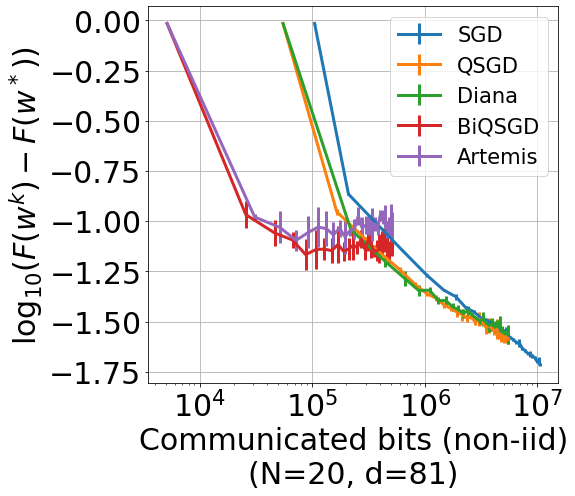

In [25]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits (non-iid)", all_error=res.get_std(obj)) 

## With averaging

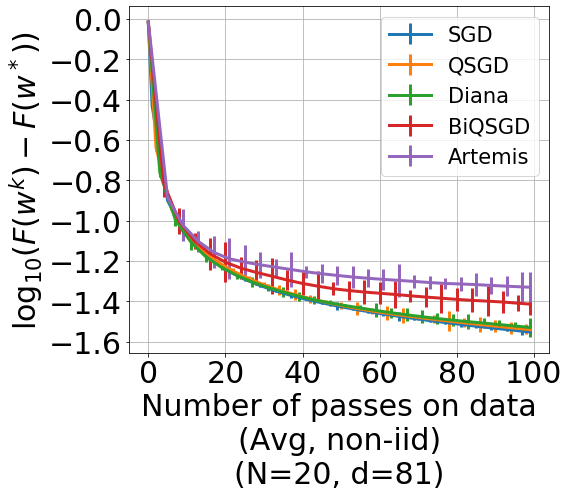

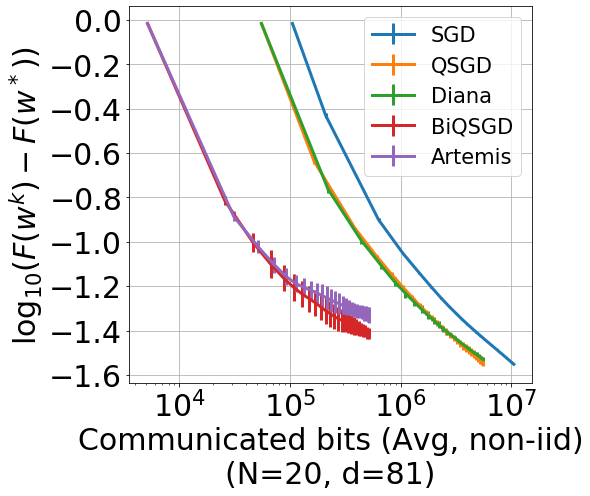

In [26]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=False), 
                x_legend="Number of passes on data\n(Avg, non-iid)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), 
                x_legend="Communicated bits (Avg, non-iid)") 


## Batch size $= 50$ (stochastic)

In [27]:
%%time
batch_size = 50
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               use_averaging=True, batch_size=batch_size, 
                                               nb_epoch=1000, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, filename + "-noniid-descent-{0}".format(batch_size))

100%|██████████| 5/5 [45:35<00:00, 547.00s/it]

CPU times: user 9h 58min 48s, sys: 42min 13s, total: 10h 41min 2s
Wall time: 45min 35s


In [28]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

Model obtain from Vanilla SGD descent, the first value corresponds to the bias: 
tensor([ 0.0186, -0.0061,  0.1138, -0.0445,  0.0765,  0.0258, -0.0956,  0.0596,
         0.2709, -0.0270,  0.1031, -0.1561, -0.0283,  0.0373,  0.0497,  0.0921,
         0.1033,  0.0543,  0.1720,  0.0991, -0.1921, -0.1558,  0.0156,  0.2607,
        -0.1235,  0.0230,  0.0716,  0.1134,  0.2226, -0.2449, -0.1266,  0.2351,
        -0.1366, -0.0517, -0.1126,  0.0487, -0.0464, -0.1640, -0.1689,  0.0805,
         0.1589, -0.1524,  0.1691,  0.0770,  0.0030, -0.2789, -0.0582, -0.2006,
        -0.3455, -0.1372,  0.3976, -0.1399,  0.0743, -0.0170, -0.0459, -0.0395,
        -0.0214,  0.2547, -0.0651,  0.1350, -0.0143, -0.0649,  0.0605,  0.4507,
        -0.0629, -0.2543, -0.0309,  0.1360, -0.1666, -0.1733, -0.0014,  0.2876,
         0.0024, -0.0357,  0.0332, -0.0295,  0.0577, -0.0706,  0.0514,  0.1522,
         0.0066, -0.2335], dtype=torch.float64)


## Without averaging

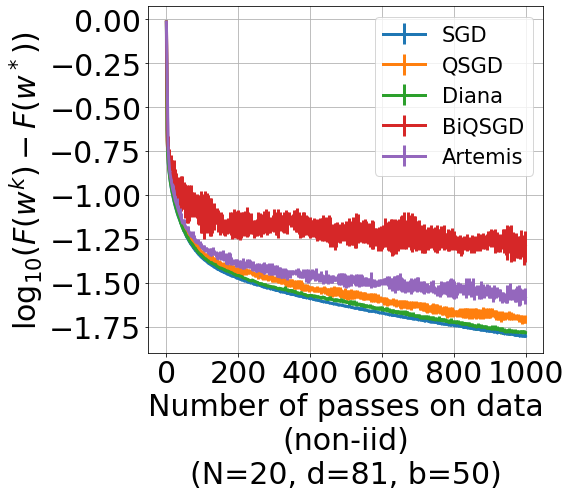

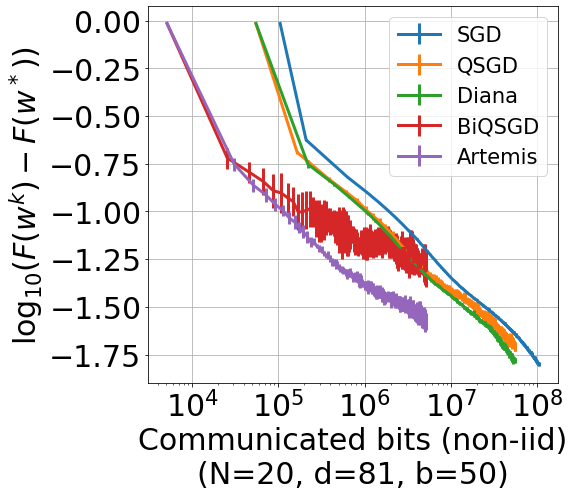

In [29]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-noniid-descent-{1}".format(filename, batch_size))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,  batch_size=batch_size,
                x_points=res.X_number_of_bits, x_legend="Communicated bits (non-iid)", all_error=res.get_std(obj)) 

## With averaging

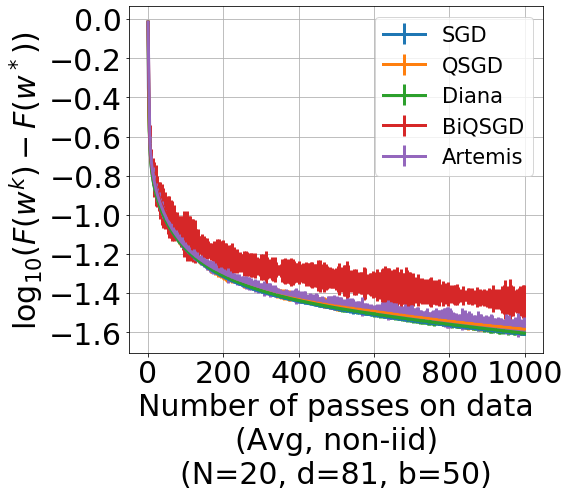

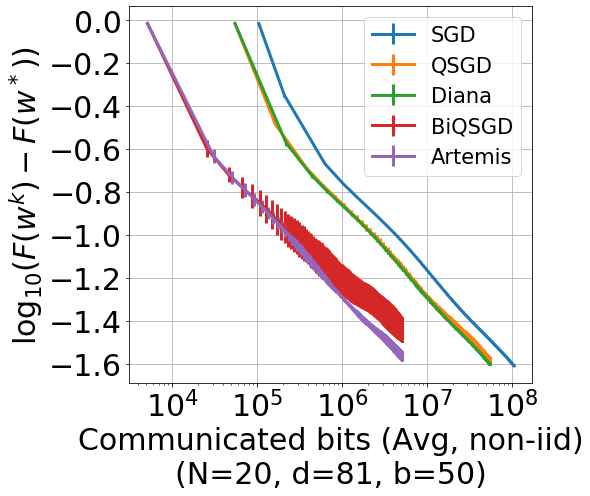

In [30]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-noniid-descent-{1}".format(filename, batch_size))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=False), batch_size=batch_size,
                x_legend="Number of passes on data\n(Avg, non-iid)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), batch_size=batch_size,
                x_legend="Communicated bits (Avg, non-iid)") 